#### Prepare Environment

In [23]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Algorithms
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Performance metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, auc, 
                            precision_recall_curve, PrecisionRecallDisplay)

# sampling methods
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks

# 공정성 모델
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing

import joblib
import shap
import optuna

import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import seaborn as sns

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
# 데이터 전처리 함수
from functions import *

# 1. EDA

## 1-1. 원 데이터

In [3]:
# Define the XPT file path
xpt_file_path = './LLCP2021.XPT'

# Load the XPT file
df, meta = pyreadstat.read_xport(xpt_file_path)

- 심장질환 음성이 92%, 양성이 8%로 매우 불균형한 데이터

In [4]:
df['_MICHD'].value_counts(normalize=True)

_MICHD
2.0    0.918621
1.0    0.081379
Name: proportion, dtype: float64

# 2. Feature Engineering

**BRFSS 2021 Codebook:** https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf

**종속변수:**
*   심장질환 여부 --> _MICHD


**독립변수:**

*   고혈압 여부 --> _RFHYPE6
*   고콜레스테롤 여부  --> TOLDHI3
*   최근 콜레스테롤 수치 검사 여부 --> CHOLCHK3
*   체질량지수 (BMI) --> _BMI5
*   흡연 여부 --> SMOKE100
*   뇌졸중 여부 --> CVDSTRK3
*   당뇨병 여부 --> DIABETE4
*   신체활동 수준 --> _TOTINDA
*   과일 섭취 수준 --> _FRTLT1A
*   채소 섭취 수준 --> _VEGLT1A
*   과도한 음주 여부 --> _RFDRHV7
*   의료보험 가입 여부  --> _HLTHPLN
*   의료비 부담 여부 --> MEDCOST1
*   전반적인 건강 상태 --> GENHLTH
*   정신건강 상태 --> MENTHLTH
*   신체건강 상태 --> PHYSHLTH
*   걷기 어려움 여부 --> DIFFWALK
*   성별 --> _SEX
*   연령대 --> _AGEG5YR
*   교육 수준 --> EDUCA
*   가구 소득 수준 --> INCOME3

In [5]:
# 변수 선정
data = df[['_MICHD',
            '_RFHYPE6',
            'TOLDHI3', 'CHOLCHK3',
            '_BMI5',
            'SMOKE100',
            'CVDSTRK3', 'DIABETE4',
            '_TOTINDA',
            '_FRTLT1A', '_VEGLT1A',
            '_RFDRHV7',
            '_HLTHPLN', 'MEDCOST1',
            'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK',
            '_SEX', '_AGEG5YR', 'EDUCA', 'INCOME3']]

In [6]:
# 결측치 제거
data.dropna(inplace=True)
data.shape

(330355, 22)

In [7]:
# 모름, 응답거부 제거 등 전처리
data_cleaned = get_preprocessed(data)

In [8]:
data_cleaned.head()

,_MICHD,_RFHYPE6,TOLDHI3,CHOLCHK3,_BMI5,SMOKE100,CVDSTRK3,DIABETE4,_TOTINDA,_FRTLT1A,...,_HLTHPLN,MEDCOST1,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK,_SEX,_AGEG5YR,EDUCA,INCOME3
0,0.0,0.0,1.0,1.0,15.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,10.0,20.0,0.0,0.0,11.0,4.0,5.0
2,1.0,1.0,0.0,1.0,28.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,4.0,3.0
3,0.0,1.0,1.0,1.0,33.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,10.0,0.0,0.0,0.0,9.0,4.0,7.0
4,1.0,0.0,1.0,1.0,29.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,5.0,0.0,30.0,1.0,1.0,12.0,3.0,4.0
5,0.0,0.0,0.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,1.0,13.0,5.0,6.0


In [9]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236378 entries, 0 to 438692
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _MICHD    236378 non-null  float64
 1   _RFHYPE6  236378 non-null  float64
 2   TOLDHI3   236378 non-null  float64
 3   CHOLCHK3  236378 non-null  float64
 4   _BMI5     236378 non-null  float64
 5   SMOKE100  236378 non-null  float64
 6   CVDSTRK3  236378 non-null  float64
 7   DIABETE4  236378 non-null  float64
 8   _TOTINDA  236378 non-null  float64
 9   _FRTLT1A  236378 non-null  float64
 10  _VEGLT1A  236378 non-null  float64
 11  _RFDRHV7  236378 non-null  float64
 12  _HLTHPLN  236378 non-null  float64
 13  MEDCOST1  236378 non-null  float64
 14  GENHLTH   236378 non-null  float64
 15  MENTHLTH  236378 non-null  float64
 16  PHYSHLTH  236378 non-null  float64
 17  DIFFWALK  236378 non-null  float64
 18  _SEX      236378 non-null  float64
 19  _AGEG5YR  236378 non-null  float64
 20  EDUCA    

- 변수 선정 및 결측치 제거 후에도 음성 92%, 양성 8%의 매우 불균형한 데이터

In [10]:
data_cleaned['_MICHD'].value_counts(normalize=True)

_MICHD
0.0    0.913452
1.0    0.086548
Name: proportion, dtype: float64

# 3. 모델 설계

## 3-1. 1차 시도
- 최종 선정된 resampling 기법인 Tomek Links 와 SMOTEENN, LightGBM과 Logistic Regression 모델만 소개한다. 

### (1) SMOTEENN & Logistic Regression

In [31]:
X = data_cleaned.drop('_MICHD', axis = 1)
y = data_cleaned['_MICHD']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=y)
resample = SMOTEENN(random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

# 필요시 resampled 데이터 저장
# X_test = pd.read_csv('./X_test_smoteenn.csv')
# y_test = pd.read_csv('./y_test_smoteenn.csv')
# X_train = pd.read_csv('./X_train_smoteenn.csv')
# y_train = pd.read_csv('./y_train_smoteenn.csv')

model = LogisticRegression(random_state=42, class_weight='balanced') # 클래스 불균형 완화 위해 class_weight='balanced' 설정
model.fit(X_train, y_train)  

pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 

# 평가
acc_train = accuracy_score(y_train, pred_train)
pre_train = precision_score(y_train, pred_train)
re_train = recall_score(y_train, pred_train)
f1_train = f1_score(y_train, pred_train)
aucc_train = roc_auc_score(y_train, pred_train)

acc_test = accuracy_score(y_test, pred_test)
pre_test = precision_score(y_test, pred_test)
re_test = recall_score(y_test, pred_test)
f1_test = f1_score(y_test, pred_test)
aucc_test = roc_auc_score(y_test, pred_test)

print('SMOTEENN & Logistic Regression')
print('test_size = 0.3, random_state=42, class_weight=balanced')
print('-'*60)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [acc_train, acc_test],
    'precision': [pre_train, pre_test],
    'recall': [re_train, re_test],
    'F1-score': [f1_train, f1_test],
    'roc_auc': [aucc_train, aucc_test],
})

display(scores)

SMOTEENN & Logistic Regression
test_size = 0.3, random_state=42, class_weight=balanced
------------------------------------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.855103,0.886207,0.866153,0.876066,0.852636
1,Test,0.701328,0.202036,0.831025,0.325048,0.760033


In [32]:
# 필요시 모델 저장

joblib.dump(model, './model_smoteenn_lr.pkl')

['./model_smoteenn_lr.pkl']

### (2) Tomek Links & LightGBM

In [33]:
X = data_cleaned.drop('_MICHD', axis = 1)
y = data_cleaned['_MICHD']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=y)
resample = TomekLinks()
X_train, y_train = resample.fit_resample(X_train, y_train)

# 필요시 resampled 데이터 저장
# X_test = pd.read_csv('./X_test_tomeklinks.csv')
# y_test = pd.read_csv('./y_test_tomeklinks.csv')
# X_train = pd.read_csv('./X_train_tomeklinks.csv')
# y_train = pd.read_csv('./y_train_tomeklinks.csv')

model = LGBMClassifier(random_state=42, scale_pos_weight=10) # 음성이 양성의 10배이므로 scale_pos_weight=10 설정
model.fit(X_train, y_train)  # 모델 학습

pred_train = model.predict(X_train)  # training set 예측
pred_test = model.predict(X_test)  # test set 예측

# 평가
acc_train = accuracy_score(y_train, pred_train)
pre_train = precision_score(y_train, pred_train)
re_train = recall_score(y_train, pred_train)
f1_train = f1_score(y_train, pred_train)
aucc_train = roc_auc_score(y_train, pred_train)

acc_test = accuracy_score(y_test, pred_test)
pre_test = precision_score(y_test, pred_test)
re_test = recall_score(y_test, pred_test)
f1_test = f1_score(y_test, pred_test)
aucc_test = roc_auc_score(y_test, pred_test)

print('TomekLinks & LightGBM')
print('test_size = 0.3, random_state=42, stratify=y')
print('-'*60)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [acc_train, acc_test],
    'precision': [pre_train, pre_test],
    'recall': [re_train, re_test],
    'F1-score': [f1_train, f1_test],
    'roc_auc': [aucc_train, aucc_test],
})

display(scores)

TomekLinks & LightGBM
test_size = 0.3, random_state=42, stratify=y
------------------------------------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.755353,0.242907,0.832135,0.376043,0.790012
1,Test,0.740305,0.221855,0.797947,0.347182,0.766396


In [34]:
# 필요시 모델 저장

joblib.dump(model, './model_tomeklinks_lgbm.pkl')

['./model_tomeklinks_lgbm.pkl']

### (3) 분석

#### SHAP

- 연령대 변수가 모델의 판단에 매우 큰 영향을 미친다는 점 확인가능
- 계산 비용이 큰 KernelExplainer 대신 TreeExplainer를 사용하기 위해 LightGBM 모델로 테스트

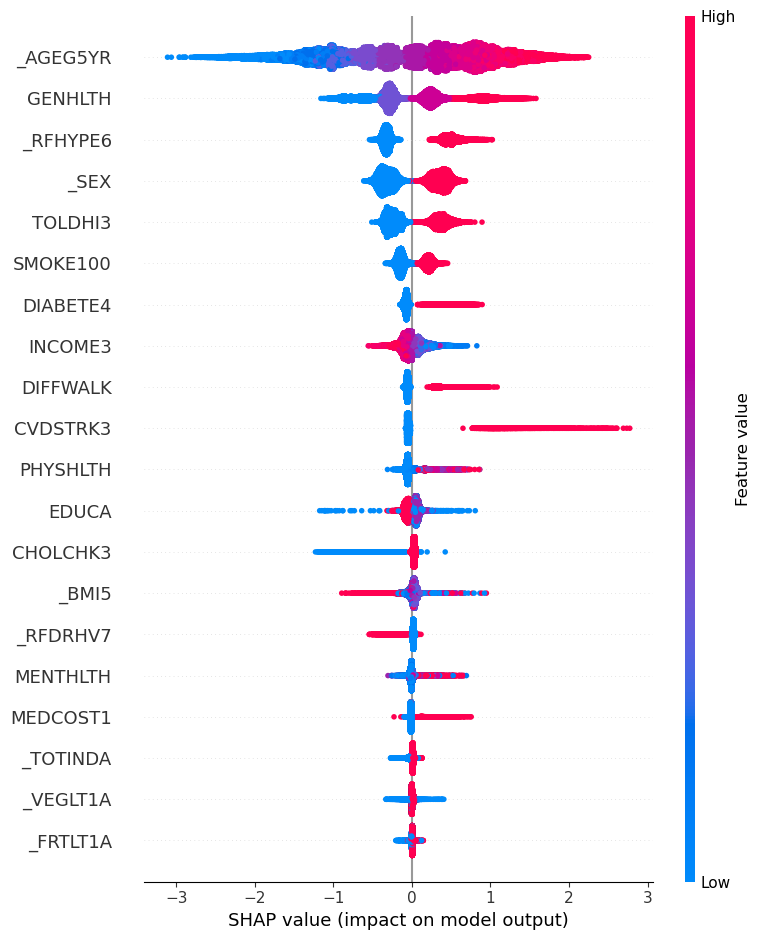

In [35]:
model = joblib.load('./model_tomeklinks_lgbm.pkl')

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 시각화
shap.summary_plot(shap_values[1], X_test)

#### 오분류 분석 - 1

In [19]:
# 오분류 분석 위한 데이터 준비

test = X_test
test['label'] = y_test
test['prediction'] = pred_test

- 나이대별 정답/오답 비교
- 연령대가 높아질수록 오답이 많아지는 모습을 확인할 수 있다. 

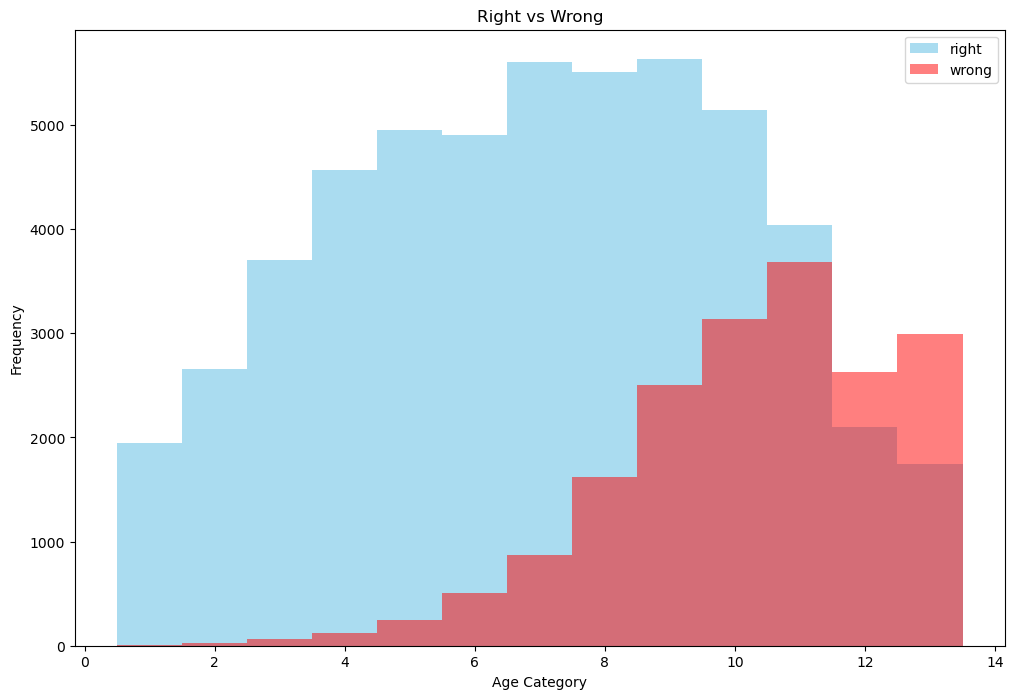

In [21]:
right = test[test['label']==test['prediction']] # 정답
wrong = test[test['label']!=test['prediction']] # 오답

counts_right = right['_AGEG5YR'].value_counts().sort_index()
counts_wrong = wrong['_AGEG5YR'].value_counts().sort_index()

# 공통 인덱스 확보
all_indexes = counts_right.index.union(counts_wrong.index)

# 빈도수를 DataFrame으로 합치고 NaN은 0으로 채우기
counts_df = pd.DataFrame({
    'right': counts_right.reindex(all_indexes, fill_value=0),
    'wrong': counts_wrong.reindex(all_indexes, fill_value=0)
})

# 플롯 생성
plt.figure(figsize=(12, 8))

# 맞게 분류된 데이터
plt.bar(counts_df.index, counts_df['right'], color='skyblue', width=1, label='right', alpha=0.7)

# 틀리게 분류된 데이터
plt.bar(counts_df.index, counts_df['wrong'], color='red', width=1, label='wrong', alpha=0.5)

plt.title('Right vs Wrong')
plt.xlabel('Age Category')
plt.ylabel('Frequency')
plt.legend()

plt.show()


#### 오분류 분석 - 2

- 고연령대의 오답이 대부분 False Positive 임을 알 수 있다. 

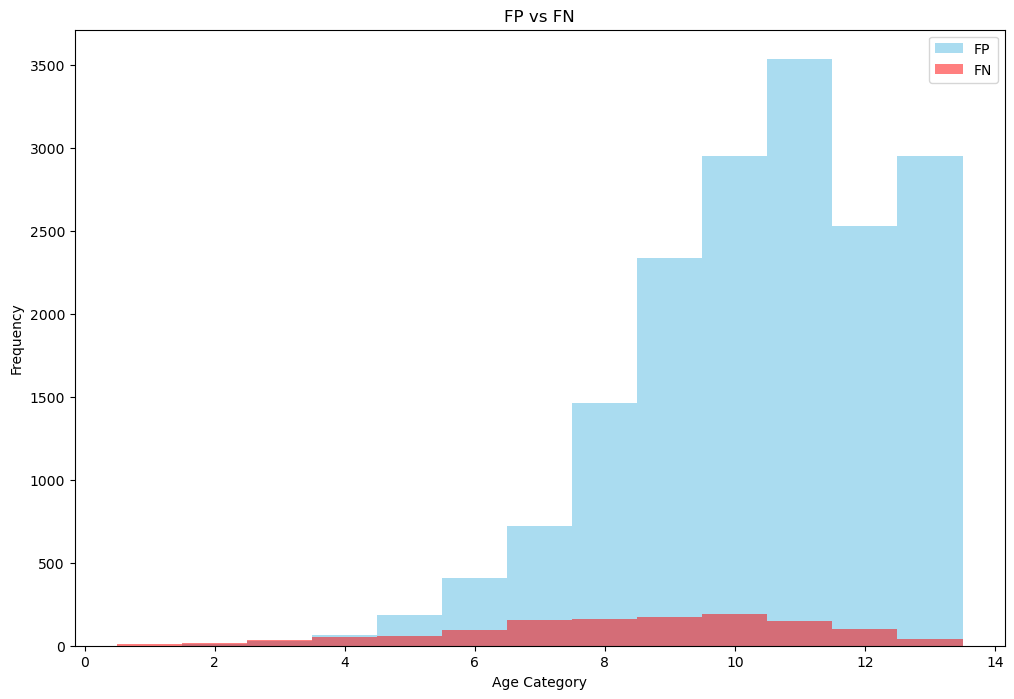

In [22]:
fp = test[(test['label']==0)&(test['prediction']==1)] #false positive
fn = test[(test['label']==1)&(test['prediction']==0)] #false negative

counts_fp = fp['_AGEG5YR'].value_counts().sort_index()
counts_fn = fn['_AGEG5YR'].value_counts().sort_index()

# 공통 인덱스 확보
all_indexes = counts_fp.index.union(counts_fn.index)

# 빈도수를 DataFrame으로 합치고 NaN은 0으로 채우기
counts_df = pd.DataFrame({
    'FP': counts_fp.reindex(all_indexes, fill_value=0),
    'FN': counts_fn.reindex(all_indexes, fill_value=0)
})

# 플롯 생성
plt.figure(figsize=(12, 8))

# 맞게 분류된 데이터
plt.bar(counts_df.index, counts_df['FP'], color='skyblue', width=1, label='FP', alpha=0.7)

# 틀리게 분류된 데이터
plt.bar(counts_df.index, counts_df['FN'], color='red', width=1, label='FN', alpha=0.5)

plt.title('FP vs FN')
plt.xlabel('Age Category')
plt.ylabel('Frequency')
plt.legend()

plt.show()


## 3-2. 2차 시도

- 1차 시도의 분석 결과를 바탕으로, 연령대 편향을 제거한 공정성 모델을 구축한다. 

In [42]:
# 데이터 준비
X_test = pd.read_csv('./X_test_smoteenn.csv')
y_test = pd.read_csv('./y_test_smoteenn.csv').squeeze()
X_train = pd.read_csv('./X_train_smoteenn.csv')
y_train = pd.read_csv('./y_train_smoteenn.csv').squeeze()

# 전체 데이터셋 생성
data = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

# AIF360 데이터셋 생성
dataset = StandardDataset(data, 
                          label_name='_MICHD',
                          favorable_classes=[0],
                          protected_attribute_names=['_AGEG5YR'],
                          privileged_classes=[[1]])

# Reweighing 알고리즘 적용
rw = Reweighing(unprivileged_groups=[{'_AGEG5YR': 0}], privileged_groups=[{'_AGEG5YR': 1}])
dataset_transformed = rw.fit_transform(dataset)

# 가중치 추출
weights = dataset_transformed.instance_weights

# 원본 모델 
original_model = joblib.load('./model_smoteenn_lr.pkl')
original_model.fit(X_train, y_train)

# 공정성 개선 모델 
fair_model = joblib.load('./model_smoteenn_lr.pkl')
fair_model.fit(X_train, y_train, sample_weight=weights)

# 예측 및 성능 평가 함수
def evaluate_model(model, X, y, name):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    pre = precision_score(y, pred)
    re = recall_score(y, pred)
    f1 = f1_score(y, pred)
    aucc = roc_auc_score(y, pred)
    return pd.DataFrame({
        'Model': [name],
        'Accuracy': [acc],
        'Precision': [pre],
        'Recall': [re],
        'F1-score': [f1],
        'ROC AUC': [aucc]
    })

# 원본 모델 평가
original_train_scores = evaluate_model(original_model, X_train, y_train, "Original (Train)")
original_test_scores = evaluate_model(original_model, X_test, y_test, "Original (Test)")

# 공정성 개선 모델 평가
fair_train_scores = evaluate_model(fair_model, X_train, y_train, "Fair (Train)")
fair_test_scores = evaluate_model(fair_model, X_test, y_test, "Fair (Test)")

# 결과 출력
print("SMOTEENN & Logistic Regression (Original vs Fair)")
print('-'*50)
scores = pd.concat([original_train_scores, original_test_scores, fair_train_scores, fair_test_scores])
display(scores)

# 예측
original_train_pred = original_model.predict(X_train)
original_test_pred = original_model.predict(X_test)
fair_train_pred = fair_model.predict(X_train)
fair_test_pred = fair_model.predict(X_test)

SMOTEENN & Logistic Regression (Original vs Fair)
--------------------------------------------------


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Original (Train),0.855103,0.886207,0.866153,0.876066,0.852636
0,Original (Test),0.701328,0.202036,0.831025,0.325048,0.760033
0,Fair (Train),0.853820,0.882196,0.868776,0.875435,0.850480
0,Fair (Test),0.696435,0.199508,0.832491,0.321877,0.758018


- 나이대별 정답률 비교
- 나이 편향 제거시, 고연령대에서 정답률이 미세하게 상승함을 알 수 있다. 

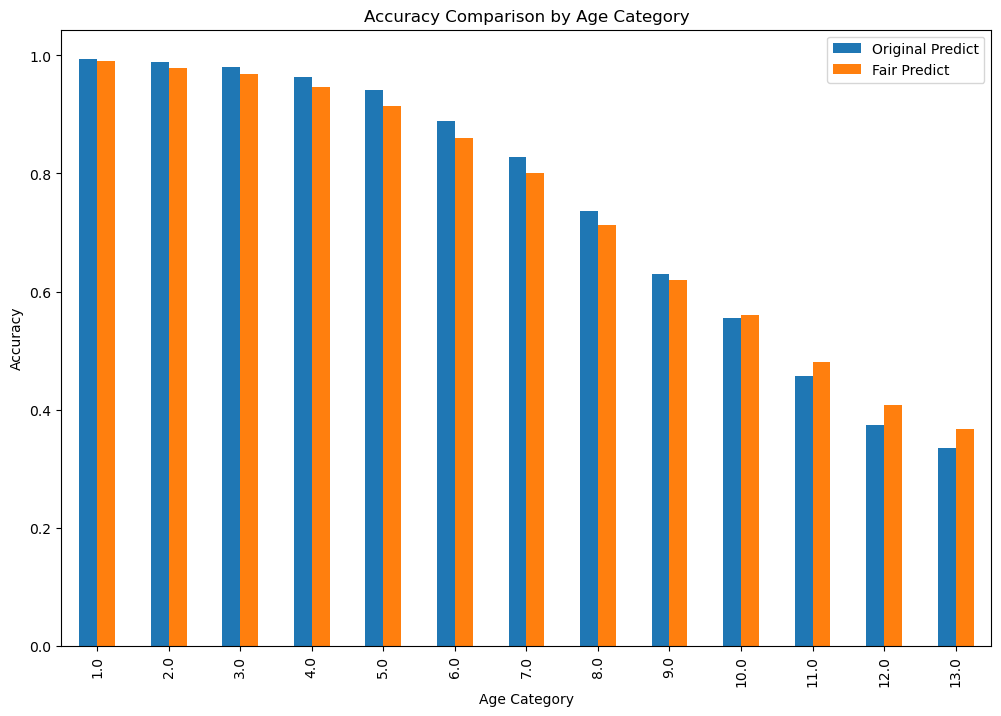

In [43]:
# 나이대별 정답률
test = X_test
test['label'] = y_test
test['original_predict'] = original_test_pred # 원 모델
test['fair_predict'] = fair_test_pred # 공정성 모델

# 데이터 준비
test = pd.DataFrame({
    'label': y_test,
    'original_predict': original_test_pred,
    'fair_predict': fair_test_pred,
    'age_cat': test['_AGEG5YR']  # age_cat 변수를 추가
})

# 나이대별 그룹화하여 정답률 계산
grouped = test.groupby('age_cat').apply(lambda x: pd.Series({
    'original_accuracy': (x['label'] == x['original_predict']).mean(),
    'fair_accuracy': (x['label'] == x['fair_predict']).mean()
}))

# 시각화
grouped.plot(kind='bar', figsize=(12, 8))
plt.title('Accuracy Comparison by Age Category')
plt.ylabel('Accuracy')
plt.xlabel('Age Category')
plt.legend(['Original Predict', 'Fair Predict'])
plt.show()


## 3-3. 3차 시도

- 2차 시도 결과를 바탕으로, StratifiedShuffleSplit 기법을 적용하여 새로운 모델 구축
- Train set와 Test set에서 연령 비율을 일정하게 유지하여, 모델이 특정 연령대에 과적합되거나 편향되는 것을 방지
- 원 데이터셋/SMOTEENN/Tomek Links 데이터셋 중, 평가 수치가 가장 높은 SMOTEENN 데이터셋 사용

In [44]:
# '_AGEG5YR' 변수 처리 함수
# SMOTEENN으로 resampling된 데이터의 _AGEG5YR 열에 실수값이 포함되어 있으므로, 이를 반올림하여 원래의 정수형으로 변환한다.
def process_age_group(df):

    # 반올림하고 정수로 변환
    df['_AGEG5YR'] = df['_AGEG5YR'].round().astype(int)
    
    # 데이터 타입을 범주형으로 변경
    df['_AGEG5YR'] = df['_AGEG5YR'].astype('category')
    
    return df

In [45]:
# 데이터 로드
X_test = pd.read_csv('./X_test_smoteenn.csv')
y_test = pd.read_csv('./y_test_smoteenn.csv').squeeze()
X_train = pd.read_csv('./X_train_smoteenn.csv')
y_train = pd.read_csv('./y_train_smoteenn.csv').squeeze()

# X_train과 X_test에 함수 적용
X_train = process_age_group(X_train)
X_test = process_age_group(X_test)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# 인덱스 리셋
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [46]:
# StratifiedShuffleSplit을 사용하여 훈련/테스트 세트 분할 및 나이 그룹 층화
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X, X['_AGEG5YR']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 모델 학습
model = LGBMClassifier(random_state=42, scale_pos_weight=10)
model.fit(X_train, y_train)

# 예측
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# 성능 metrics 계산
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred)
    }

train_metrics = calculate_metrics(y_train, pred_train)
test_metrics = calculate_metrics(y_test, pred_test)

# 결과 출력
print('\nStratified Sampling (by age group) + LightGBM')
print('test_size = 0.3, random_state=42')
print('-'*60)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [train_metrics['accuracy'], test_metrics['accuracy']],
    'precision': [train_metrics['precision'], test_metrics['precision']],
    'recall': [train_metrics['recall'], test_metrics['recall']],
    'F1-score': [train_metrics['F1-score'], test_metrics['F1-score']],
    'roc_auc': [train_metrics['roc_auc'], test_metrics['roc_auc']],
})

display(scores)


Stratified Sampling (by age group) + LightGBM
test_size = 0.3, random_state=42
------------------------------------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.861503,0.782375,0.985347,0.872208,0.866343
1,Test,0.860624,0.782198,0.984185,0.871643,0.865184


- 고연령대에서 정답률 높아진 것 확인

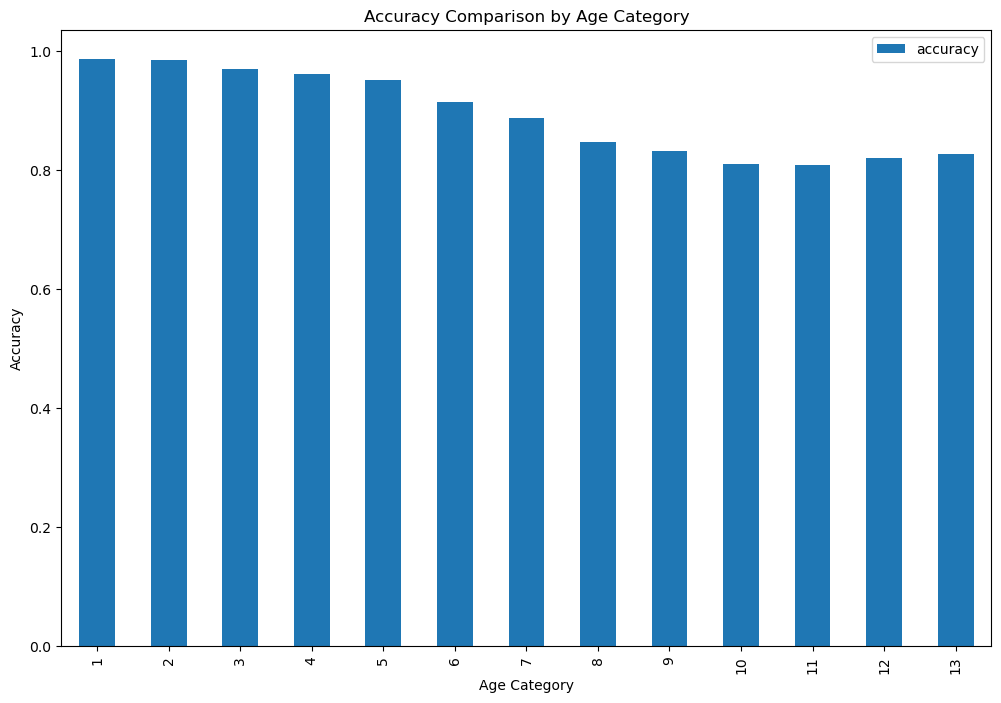

In [47]:
# 데이터 준비
test = pd.DataFrame({
    'label': y_test,
    'predict': pred_test,
    'age_cat': X_test['_AGEG5YR']
})

# 나이대별 그룹화하여 정답률 계산
grouped = test.groupby('age_cat').apply(lambda x: pd.Series({
    'accuracy': (x['label'] == x['predict']).mean(),
}))

# 시각화
grouped.plot(kind='bar', figsize=(12, 8))
plt.title('Accuracy Comparison by Age Category')
plt.ylabel('Accuracy')
plt.xlabel('Age Category')
plt.show()

## 3-4. Hyper Parameter 최적화

- Optuna 사용

In [51]:
# StratifiedShuffleSplit을 사용하여 훈련/테스트 세트 분할 및 나이 그룹 층화
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X, X['_AGEG5YR']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 하이퍼파라미터 튜닝을 위한 목적 함수
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),  # L1 regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),  # L2 regularization
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),  # Maximum number of leaves in one tree
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),  # Subsample ratio of columns when constructing each tree
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),  # Subsample ratio of the training instance
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),  # Frequency of subsample, <=0 means no enable
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Minimum number of data needed in a child (leaf)
        'scale_pos_weight': 10
    }

    model = LGBMClassifier(**param)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = roc_auc_score(y_test, pred) # roc_auc_score 기준으로 최적화 진행
    return score

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적 파라미터
best_params = study.best_trial.params

# 고정 파라미터 추가
best_params['random_state'] = 42
best_params['scale_pos_weight'] = 10

model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Train set and Test set 예측
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# 성능 metric 계산
acc_train = accuracy_score(y_train, pred_train)
pre_train = precision_score(y_train, pred_train)
re_train = recall_score(y_train, pred_train)
f1_train = f1_score(y_train, pred_train)
aucc_train = roc_auc_score(y_train, pred_train)

acc_test = accuracy_score(y_test, pred_test)
pre_test = precision_score(y_test, pred_test)
re_test = recall_score(y_test, pred_test)
f1_test = f1_score(y_test, pred_test)
aucc_test = roc_auc_score(y_test, pred_test)

print('Optuna Tuned LightGBM + Stratified SMOTEENN')
print('test_size = 0.3, random_state=42, stratify=y')
print('-'*30)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [acc_train, acc_test],
    'precision': [pre_train, pre_test],
    'recall': [re_train, re_test],
    'F1-score': [f1_train, f1_test],
    'roc_auc': [aucc_train, aucc_test],
})

display(scores)

[I 2024-07-17 20:54:36,427] A new study created in memory with name: no-name-7eb26606-23bc-49b7-90c4-89c3412d24d6
[I 2024-07-17 20:54:37,985] Trial 0 finished with value: 0.8780623859812737 and parameters: {'reg_alpha': 0.051208226534071845, 'reg_lambda': 5.260304586694668e-06, 'num_leaves': 87, 'colsample_bytree': 0.8901719337657981, 'subsample': 0.8388622646079947, 'subsample_freq': 1, 'min_child_samples': 86}. Best is trial 0 with value: 0.8780623859812737.
[I 2024-07-17 20:54:40,166] Trial 1 finished with value: 0.8824044908848422 and parameters: {'reg_alpha': 0.0005624181048591495, 'reg_lambda': 0.00016821676232469656, 'num_leaves': 132, 'colsample_bytree': 0.6165495437781012, 'subsample': 0.5095920687995401, 'subsample_freq': 4, 'min_child_samples': 40}. Best is trial 1 with value: 0.8824044908848422.
[I 2024-07-17 20:54:42,294] Trial 2 finished with value: 0.8810829285023618 and parameters: {'reg_alpha': 1.5504931285960336e-07, 'reg_lambda': 2.080476545712615e-06, 'num_leaves': 

Optuna Tuned LightGBM + Stratified SMOTEENN
test_size = 0.3, random_state=42, stratify=y
------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.908355,0.844238,0.991956,0.912155,0.911623
1,Test,0.893321,0.831336,0.976192,0.897960,0.896379


# 4. 결과 

- 전반적인 수치 향상

    - accuracy: 0.89
    - precision: 0.83
    - recall: 0.97
    - F1-score: 0.90
    - roc_auc: 0.90

In [58]:
display(scores)

,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.908355,0.844238,0.991956,0.912155,0.911623
1,Test,0.893321,0.831336,0.976192,0.897960,0.896379


## 4-1. ROC curve

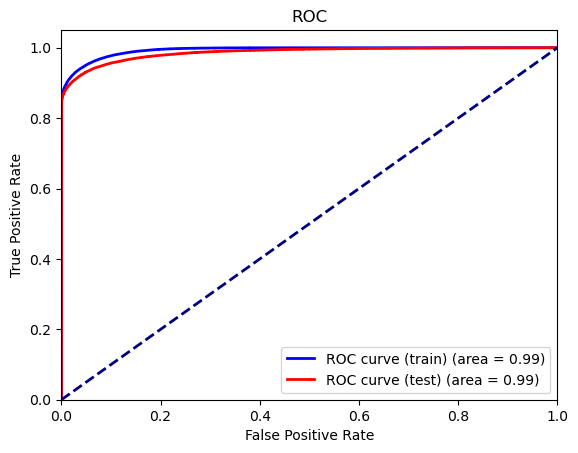

In [52]:
# ROC curve 그리기
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# 데이터
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# 시각화
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (train) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (test) (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 4-2. Precision-Recall Curve

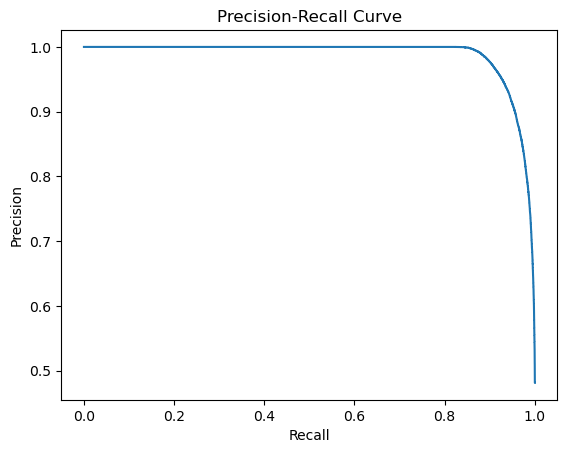

In [55]:
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

# 시각화
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.show()


## 4-3. Precision-Recall by Threshold

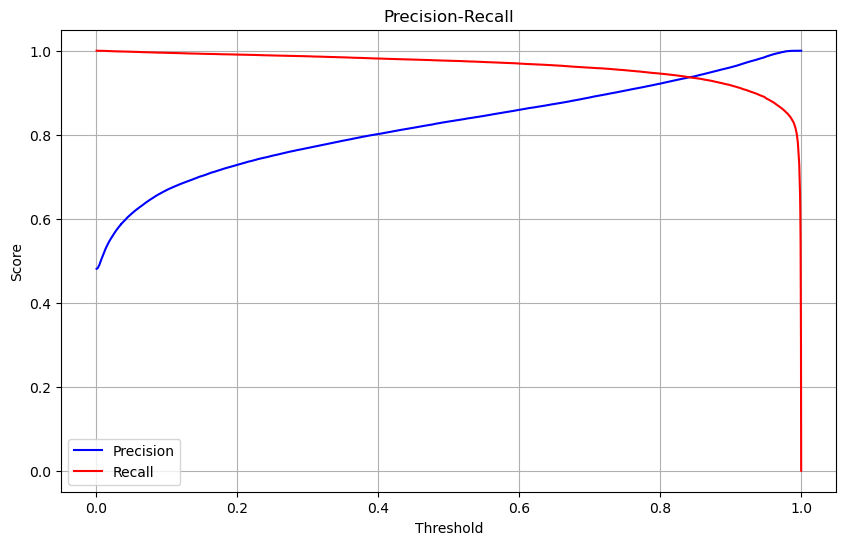

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

# F1-score 계산
f1_scores = 2 * (precision * recall) / (precision + recall)

# Precision-Recall 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 4-4. SHAP

- Feature importance 균등하게 분포함 확인

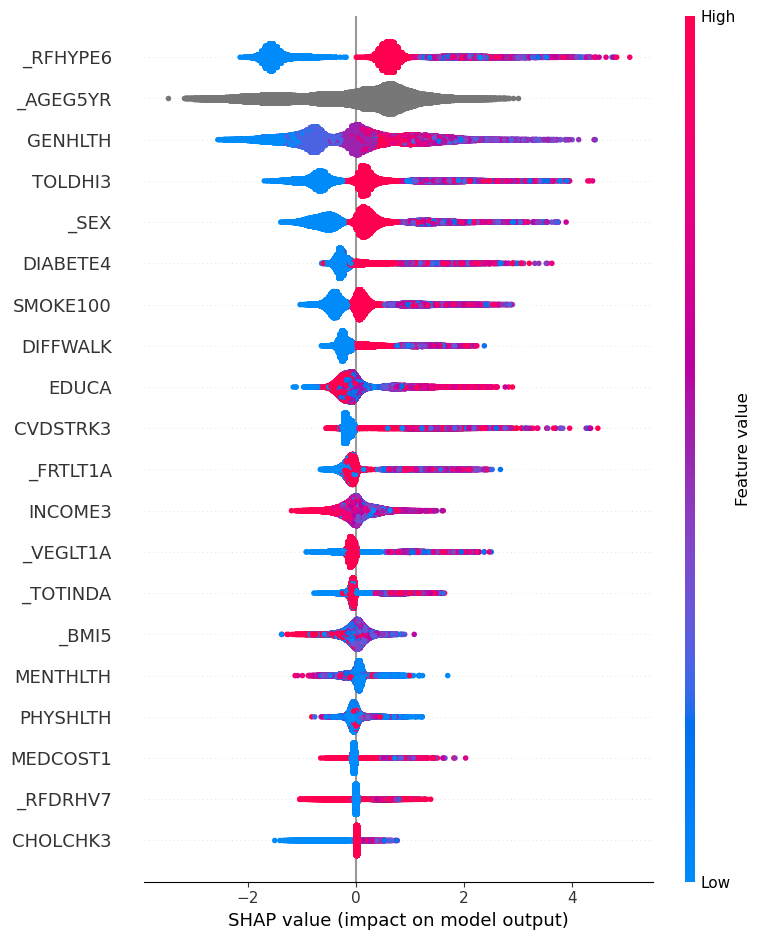

In [82]:
# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 시각화 (양성 예측)
shap.summary_plot(shap_values[1], X_test)